In [1]:
'''
WARNING
If you use google colab then run this cell and choose caps_net.py
file to upload to the colab server
otherwise ignore this cell!!!
'''
!pip install tqdm
from google.colab import files
src = list(files.upload().values())[0]
open('caps_net.py','wb').write(src)

Saving caps_net.py to caps_net.py


10220

In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from caps_net import CapsNet
from tqdm import tqdm
import time

C:\Users\16678039\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


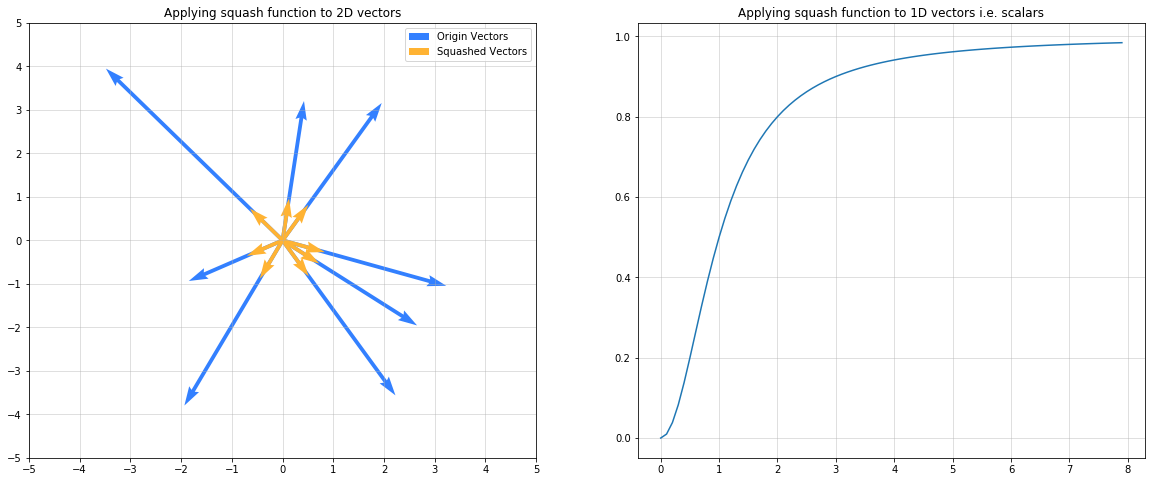

In [0]:
def squash_scalar(x):
    return x**2/(1+x**2)

def squash_vec(x):
    norm = np.linalg.norm(x)
    sq_norm = norm**2
    return sq_norm/(1.0+sq_norm)*x/norm

fig = plt.figure(figsize=(20,8))

x = np.arange(0, 8, 0.1)
y = np.array([squash_scalar(x_i) for x_i in x])

fig.add_subplot(1,2,2)
plt.plot(x, y)
plt.grid(alpha=0.5)
plt.title('Applying squash function to 1D vectors i.e. scalars')

x, y = [0], [0]
u = np.random.rand(8)*10 - 5
v = np.random.rand(8)*10 - 5
sq_vecs = np.array([squash_vec(np.array([x1, x2])) for (x1, x2) in zip(u, v)])
sq_vecs = np.transpose(sq_vecs)

fig.add_subplot(1,2,1)
plt.quiver(x, y, u, v, color =(0.2, 0.5, 1, 1), scale=1, units='xy')
plt.quiver(x, y, sq_vecs[0], sq_vecs[1], color =(1, 0.7, 0.2, 1), scale=1, units='xy')
plt.legend(['Origin Vectors', 'Squashed Vectors'], loc='upper right')
plt.title('Applying squash function to 2D vectors')
ticks = range(-5, 6)
plt.xticks(ticks)
plt.yticks(ticks)
plt.grid(alpha=0.5)

plt.show()

In [2]:
def next_batch(size, x, y):
    idx = np.arange(0 , len(x))
    np.random.shuffle(idx)
    idx = idx[:size]
    data_shuffle = [x[i] for i in idx]
    labels_shuffle = [y[i] for i in idx]
    return np.asarray(data_shuffle), np.asarray(labels_shuffle)

In [3]:
mnist = tf.keras.datasets.mnist
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()

In [4]:
tf.reset_default_graph()

INPUT_DIM = (28, 28, 1)
CLASSES = 10
LEARNING_RATE = 0.01

caps_net = CapsNet(INPUT_DIM, CLASSES,
                   decoder_layers=(512, 1024))

optimizer = tf.train.AdamOptimizer(LEARNING_RATE)
training_op = optimizer.minimize(caps_net.loss)

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

C:\Users\16678039\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [5]:
IMAGES_TO_SHOW = 5
def show_decoded_img(img_data, num_imgs):
    f, axes = plt.subplots(1, num_imgs, figsize=(15,4))
    f.suptitle('Origin images from testing set')
    for (i, ax) in enumerate(axes):
        ax.imshow(mnist_x_test[i], cmap='gray')
        ax.set_title('Label: ' + str(mnist_y_test[i]))
    for (i, img) in enumerate(img_data):
        f, axes = plt.subplots(1, num_imgs, figsize=(15,4))
        f.suptitle('Generated images from caps net decoder, epoch ' + str(i))
        for (i, ax) in enumerate(axes):
            ax.imshow(img[i], cmap='gray')
            ax.set_title('Label: ' + str(mnist_y_test[i]))
            
def get_decoded_data():
    mnist_x_batch_show = np.reshape(mnist_x_test[:IMAGES_TO_SHOW], (IMAGES_TO_SHOW, 28, 28, 1))
    decoded_imgs = sess.run(caps_net.decoded, feed_dict={caps_net.X: mnist_x_batch_show,
                                                         caps_net.Y: mnist_y_test[:IMAGES_TO_SHOW]})
    return np.reshape(decoded_imgs, (IMAGES_TO_SHOW, 28, 28))

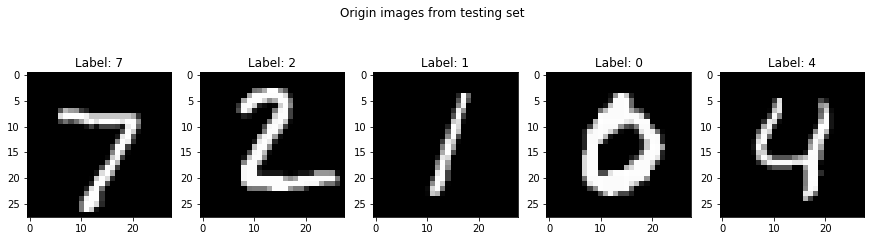

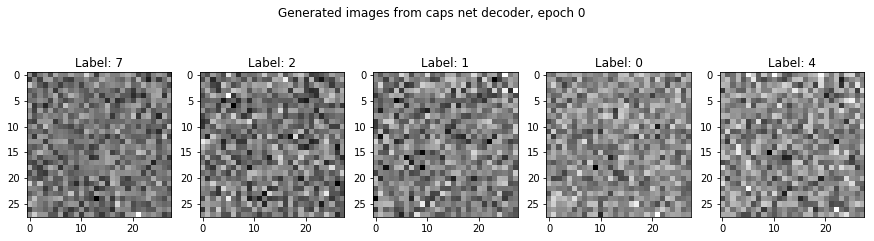

In [6]:
decoded_imgs = get_decoded_data()
show_decoded_img([decoded_imgs], IMAGES_TO_SHOW)

In [7]:
'''
Training on mnist data
'''
mnist_x_train = mnist_x_train[:100]
mnist_y_train = mnist_y_train[:100]
EPOCHES = 10
BATCH_SIZE = 10
TEST_SIZE = 10

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
imgs_data = []

mnist_num_batches = int(len(mnist_x_train)/BATCH_SIZE)
for i in range(EPOCHES):
    mnist_x_batch_test, mnist_y_batch_test = next_batch(TEST_SIZE, mnist_x_test, mnist_y_test)
    mnist_x_batch_test = np.reshape(mnist_x_batch_test, (TEST_SIZE, 28, 28, 1))
    feed_dict_test = {
        caps_net.X: mnist_x_batch_test,
        caps_net.Y: mnist_y_batch_test
    }
    margin_loss = sess.run(caps_net.margin_loss, feed_dict=feed_dict_test)
    decoder_loss = sess.run(caps_net.decoder_loss, feed_dict=feed_dict_test)
    loss = sess.run(caps_net.loss, feed_dict=feed_dict_test)
    accuracy = sess.run(caps_net.accuracy, feed_dict=feed_dict_test)
    print('Epoch %d, train margin loss %f' %(i, margin_loss))
    print('Epoch %d, train decoder loss %f' %(i, decoder_loss))
    print('Epoch %d, train total loss %f' %(i, loss))
    print('Epoch %d, accuracy %f' %(i, accuracy))
    test_accuracy.append(accuracy)
    test_losses.append([i, margin_loss, decoder_loss, loss])
    imgs_data.append(get_decoded_data())
    time.sleep(2) #For properly working tqdm
    for j in tqdm(range(mnist_num_batches)):
        mnist_x_batch, mnist_y_batch = next_batch(BATCH_SIZE, mnist_x_train, mnist_y_train)
        mnist_x_batch = np.reshape(mnist_x_batch, (BATCH_SIZE, 28, 28, 1))
        feed_dict_train = {
            caps_net.X: mnist_x_batch,
            caps_net.Y: mnist_y_batch
        }
        sess.run(training_op, feed_dict=feed_dict_train)
        if j % 1 == 0:
            margin_loss = sess.run(caps_net.margin_loss, feed_dict=feed_dict_train)
            decoder_loss = sess.run(caps_net.decoder_loss, feed_dict=feed_dict_train)
            loss = sess.run(caps_net.loss, feed_dict=feed_dict_train)
            accuracy = sess.run(caps_net.accuracy, feed_dict=feed_dict_train)
            train_accuracy.append(accuracy)
            train_losses.append([i, margin_loss, decoder_loss, loss])

Epoch 0, train margin loss 0.238864
Epoch 0, train decoder loss 7212.582520
Epoch 0, train total loss 3.845156
Epoch 0, accuracy 0.100000


100%|██████████████████████████████████████████| 10/10 [00:21<00:00,  2.10s/it]


Epoch 1, train margin loss 0.320830
Epoch 1, train decoder loss 7652.961914
Epoch 1, train total loss 4.147312
Epoch 1, accuracy 0.000000


100%|██████████████████████████████████████████| 10/10 [00:20<00:00,  2.14s/it]


Epoch 2, train margin loss 0.302982
Epoch 2, train decoder loss 7249.767578
Epoch 2, train total loss 3.927866
Epoch 2, accuracy 0.100000


100%|██████████████████████████████████████████| 10/10 [00:20<00:00,  2.09s/it]


Epoch 3, train margin loss 0.276085
Epoch 3, train decoder loss 6801.890137
Epoch 3, train total loss 3.677030
Epoch 3, accuracy 0.100000


100%|██████████████████████████████████████████| 10/10 [00:20<00:00,  2.09s/it]


Epoch 4, train margin loss 0.273216
Epoch 4, train decoder loss 7157.052246
Epoch 4, train total loss 3.851742
Epoch 4, accuracy 0.200000


100%|██████████████████████████████████████████| 10/10 [00:21<00:00,  2.10s/it]


Epoch 5, train margin loss 0.237852
Epoch 5, train decoder loss 6995.871582
Epoch 5, train total loss 3.735788
Epoch 5, accuracy 0.100000


100%|██████████████████████████████████████████| 10/10 [00:21<00:00,  2.12s/it]


Epoch 6, train margin loss 0.257232
Epoch 6, train decoder loss 7959.877930
Epoch 6, train total loss 4.237171
Epoch 6, accuracy 0.100000


100%|██████████████████████████████████████████| 10/10 [00:19<00:00,  1.96s/it]


Epoch 7, train margin loss 0.245309
Epoch 7, train decoder loss 8013.353516
Epoch 7, train total loss 4.251986
Epoch 7, accuracy 0.500000


100%|██████████████████████████████████████████| 10/10 [00:19<00:00,  1.98s/it]


Epoch 8, train margin loss 0.200715
Epoch 8, train decoder loss 7742.047852
Epoch 8, train total loss 4.071739
Epoch 8, accuracy 0.200000


100%|██████████████████████████████████████████| 10/10 [00:19<00:00,  1.95s/it]


Epoch 9, train margin loss 0.126040
Epoch 9, train decoder loss 7064.846191
Epoch 9, train total loss 3.658463
Epoch 9, accuracy 0.300000


100%|██████████████████████████████████████████| 10/10 [00:20<00:00,  2.06s/it]


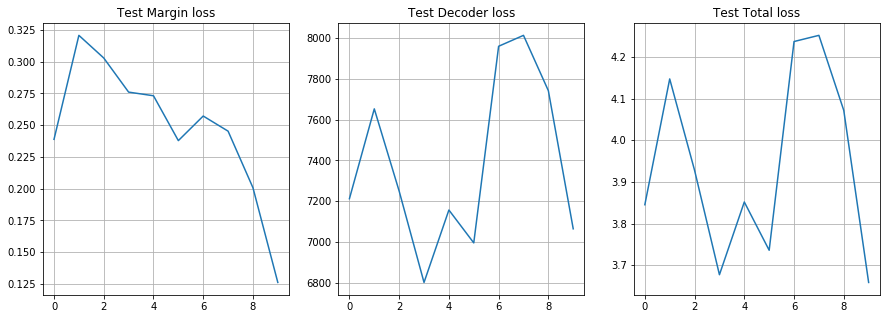

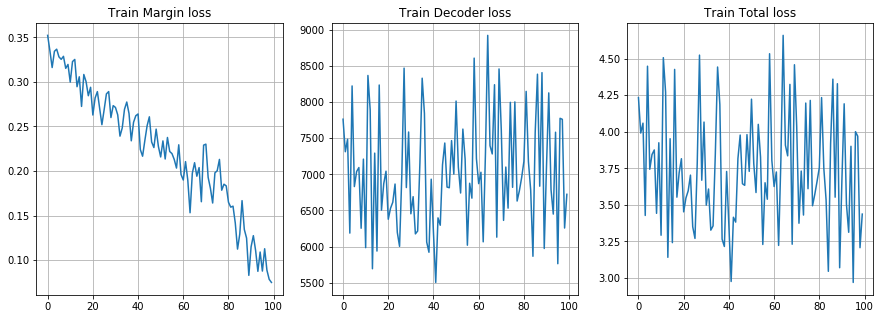

In [9]:
test_losses = np.array(test_losses)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(test_losses[:, 1])
ax1.set_title('Test Margin loss')
ax1.grid()
ax2.plot(test_losses[:, 2])
ax2.set_title('Test Decoder loss')
ax2.grid()
ax3.plot(test_losses[:, 3])
ax3.set_title('Test Total loss')
ax3.grid()
train_losses = np.array(train_losses)
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
ax1.plot(train_losses[:, 1])
ax1.set_title('Train Margin loss')
ax1.grid()
ax2.plot(train_losses[:, 2])
ax2.set_title('Train Decoder loss')
ax2.grid()
ax3.plot(train_losses[:, 3])
ax3.set_title('Train Total loss')
ax3.grid()

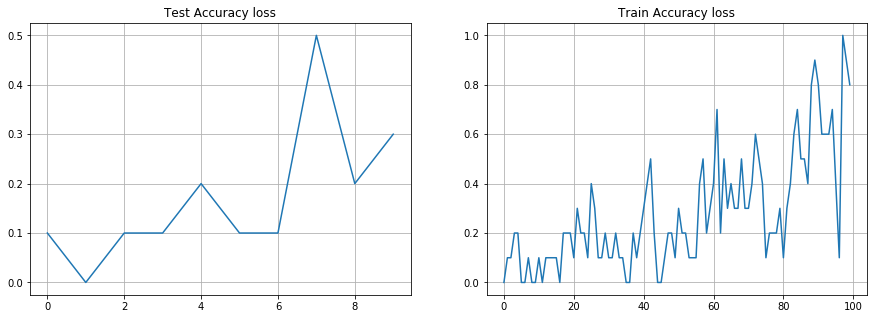

In [10]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax1.plot(test_accuracy)
ax1.set_title('Test Accuracy loss')
ax1.grid()
ax2.plot(train_accuracy)
ax2.set_title('Train Accuracy loss')
ax2.grid()

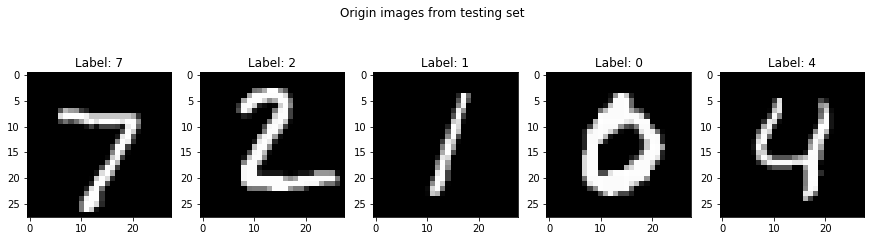

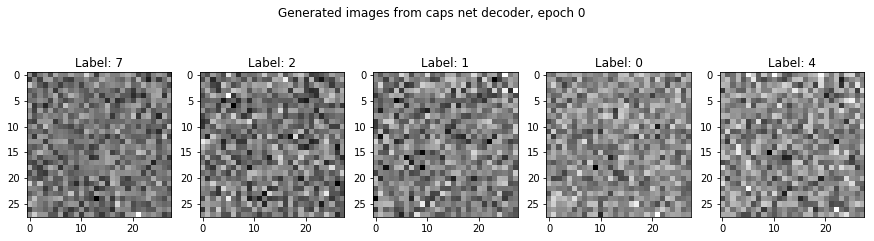

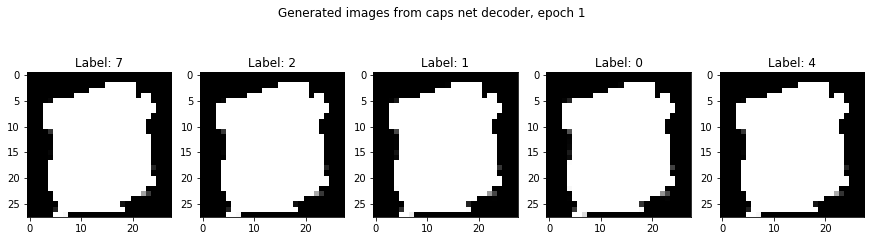

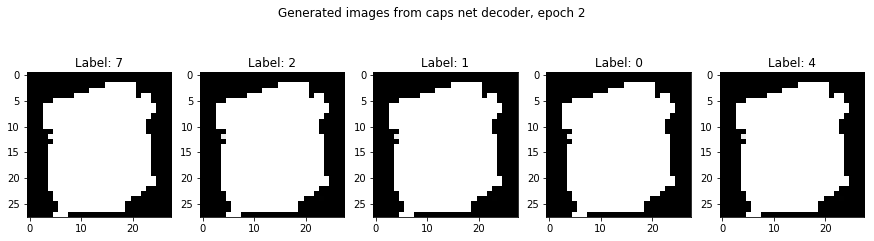

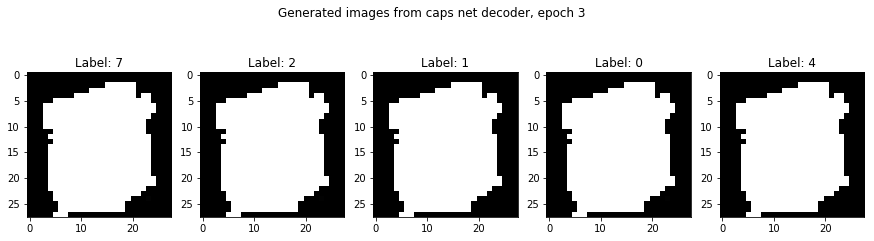

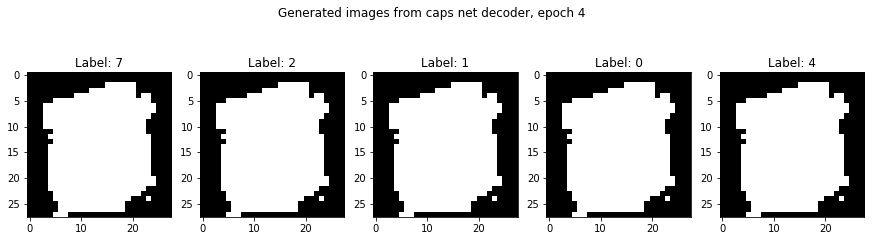

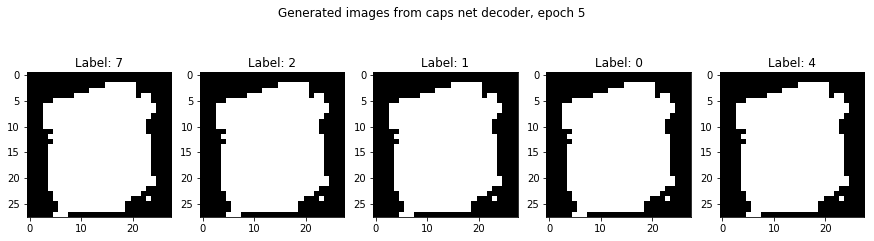

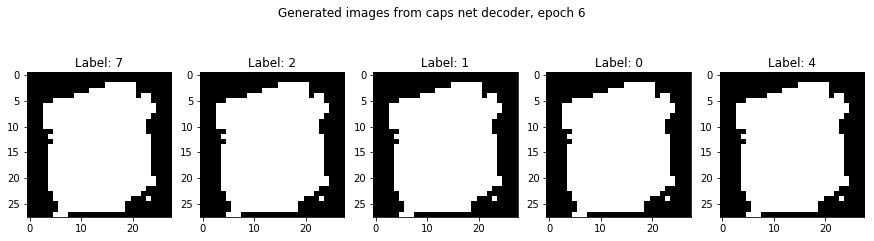

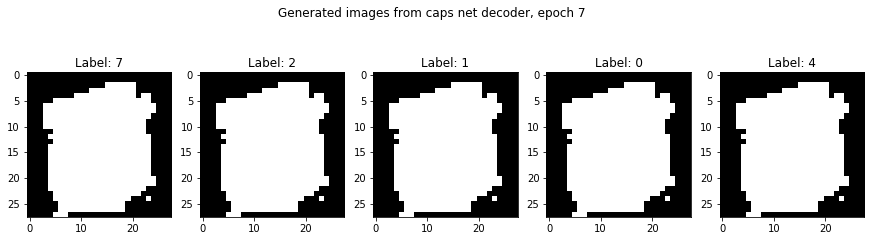

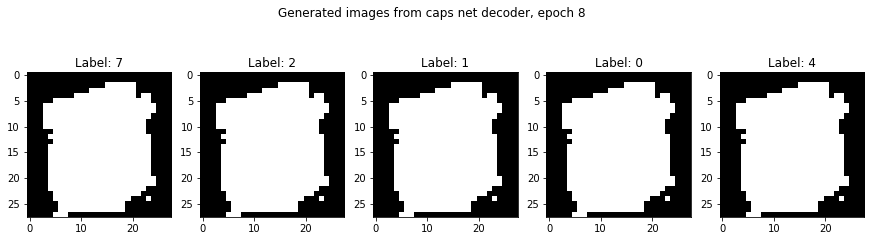

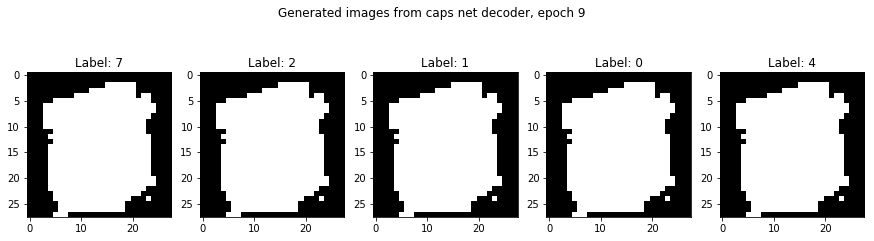

In [11]:
show_decoded_img(imgs_data, IMAGES_TO_SHOW)